In [1]:
%matplotlib notebook

<IPython.core.display.Javascript object>


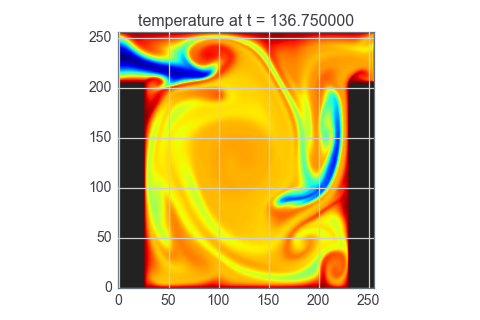

In [2]:
import numpy as np
import sympy as sp
import mpi4py.MPI as mpi

import pyLBM

X, Y, LA = sp.symbols('X, Y, LA')
rho, qx, qy, T = sp.symbols('rho, qx, qy, T')

def init_T(x, y):
    return T0

def bc(f, m, x, y):
    m[qx] = 0.
    m[qy] = 0.
    m[T] = T0

def bc_in(f, m, x, y):
    np.random.seed(1)
    m[qx] = rhoo*uo
    m[qy] = 0.
    m[T] = T0 + (Tin - T0)*(ymax-y)*(y-.8)*100

def save(mpi_topo, x, y, m, num):
    h5 = pyLBM.H5File(mpi_topo, filename, path, num)
    h5.set_grid(x, y)
    h5.add_vector('velocity', [sol.m[qx], sol.m[qy]])
    h5.add_scalar('Vx', sol.m[qx])
    h5.add_scalar('T', sol.m[T])
    h5.save()

# parameters
Tf = 100.
T0 = .5
Tin =  -.5
xmin, xmax, ymin, ymax = 0., 1., 0., 1.
Ra = 2000
Pr = 0.71
Ma = 0.01
alpha = .005
dx = 1./256 # spatial step
la = 1. # velocity of the scheme
rhoo = 1.
g = 9.81
uo = 0.025

nu = np.sqrt(Pr*alpha*9.81*(T0-Tin)*(ymax-ymin)/Ra)
kappa = nu/Pr
eta = nu

snu = 1./(.5+3*nu)
seta = 1./(.5+3*eta)
sq = 8*(2-snu)/(8-snu)
se = seta
sf = [0., 0., 0., seta, se, sq, sq, snu, snu]

a = .5
skappa = 1./(.5+10*kappa/(4+a))
se = 1./(.5+np.sqrt(3)/3)
snu = se
sT = [0., skappa, skappa, se, snu]

dico = {
    'box':{'x':[xmin, xmax], 'y':[ymin, ymax], 'label':[1, 2, 0, 0]},
    'elements':[
        pyLBM.Parallelogram([xmin, ymin], [ .1, 0], [0, .8], label=0),
        pyLBM.Parallelogram([xmax, ymin], [-.1, 0], [0, .8], label=0),
    ],
    'space_step':dx,
    'scheme_velocity':la,
    'schemes':[
        {
            'velocities': list(range(9)),
            'conserved_moments': [rho, qx, qy],
            'polynomials':[
                1, X, Y,
                3*(X**2+Y**2)-4,
                0.5*(9*(X**2+Y**2)**2-21*(X**2+Y**2)+8),
                3*X*(X**2+Y**2)-5*X, 3*Y*(X**2+Y**2)-5*Y,
                X**2-Y**2, X*Y
            ],
            'relaxation_parameters':sf,
            'equilibrium':[
                rho, qx, qy,
                -2*rho + 3*(qx**2+qy**2),
                rho - 3*(qx**2+qy**2),
                -qx, -qy,
                qx**2 - qy**2, qx*qy
            ],
            'source_terms':{qy: alpha*g*T},
            'init':{rho: 1., qx: 0., qy: 0.},

        },
        {
            'velocities': list(range(5)),
            'conserved_moments':T,
            'polynomials':[1, X, Y, 5*(X**2+Y**2) - 4, (X**2-Y**2)],
            'equilibrium':[T, T*qx, T*qy, a*T, 0.],
            'relaxation_parameters':sT,
            'init':{T:(init_T,)},
        },
    ],
    'boundary_conditions':{
        0:{'method':{0: pyLBM.bc.Bouzidi_bounce_back, 1: pyLBM.bc.Bouzidi_anti_bounce_back}, 'value':bc},
        1:{'method':{0: pyLBM.bc.Bouzidi_bounce_back, 1: pyLBM.bc.Bouzidi_anti_bounce_back}, 'value':bc_in},
        2:{'method':{0: pyLBM.bc.Neumann_y, 1: pyLBM.bc.Neumann_y}, 'value':None},
    },
    'generator': "cython",
}

sol = pyLBM.Simulation(dico)

# create the viewer to plot the solution
viewer = pyLBM.viewer.matplotlibViewer
fig = viewer.Fig()
ax = fig[0]
im = ax.image(sol.m[T].transpose(), cmap='jet', clim=[Tin, T0])
ax.title = 'solution at t = {0:f}'.format(sol.t)
ax.polygon([[xmin/dx, ymin/dx],[xmin/dx, (ymin+.8)/dx], [(xmin+.1)/dx, (ymin+.8)/dx], [(xmin+.1)/dx, ymin/dx]], 'k')
ax.polygon([[(xmax-.1)/dx, ymin/dx],[(xmax-.1)/dx, (ymin+.8)/dx], [xmax/dx, (ymin+.8)/dx], [xmax/dx, ymin/dx]], 'k')

def update(iframe):
    nrep = 64
    for i in range(nrep):
        sol.one_time_step()
    im.set_data(sol.m[T].transpose())
    ax.title = 'temperature at t = {0:f}'.format(sol.t)

fig.animate(update, interval=1)
fig.show()